In [7]:
# Cell 1: Installing Necessary Libraries
get_ipython().system('pip install tensorflow')
get_ipython().system('pip install opencv-python')
get_ipython().system('pip install pillow')
get_ipython().system('pip install torch torchvision')
get_ipython().system('pip install fiftyone --user')
# Update pyarrow to meet pymilvus requirements
get_ipython().system('pip install --upgrade pyarrow')
import pyarrow
print("PyArrow Version:", pyarrow.__version__)

PyArrow Version: 15.0.2


In [1]:
# Cell 2: Setup and Dataset Loading
import fiftyone as fo
import fiftyone.zoo as foz

# Load the LFW dataset as an example
dataset = foz.load_zoo_dataset("lfw")
print(dataset)


Migrating database to v0.23.8
 100% |██████████████████████████████████████████████|    1.3Gb/1.3Gb [1.4m elapsed, 0s remaining, 22.6Mb/s]      
Unpacking images...
 100% |████████████████████████████████████████████|  221.4Kb/221.4Kb [50.4ms elapsed, 0s remaining, 4.4Mb/s] 
 100% |████████████████████████████████████████████|  518.8Kb/518.8Kb [95.3ms elapsed, 0s remaining, 5.3Mb/s]    
Reorganizing images into splits...
Creating test split...
 100% |███████████████| 1711/1711 [2.1s elapsed, 0s remaining, 837.5 samples/s]      
Creating train split...
 100% |███████████████| 4038/4038 [5.1s elapsed, 0s remaining, 611.5 samples/s]      
Parsing dataset metadata
Found 9525 samples
Parsing dataset metadata
Found 3708 samples
Dataset info written to 'C:\Users\jabax\fiftyone\lfw\info.json'
Loading 'lfw' split 'train'
 100% |███████████████| 9525/9525 [3.0s elapsed, 0s remaining, 3.2K samples/s]      
Loading 'lfw' split 'test'
 100% |███████████████| 3708/3708 [1.1s elapsed, 0s remaining, 3

In [2]:
import torch
import torchvision.transforms as transforms
from PIL import Image, ExifTags
import cv2
import numpy as np


#YOLOv8 object detection class for human faces
#Takes file path to location where model is saved as constructor argument
#Once a YoloPreprocessor object is instantiated, use the process_image function with a cv2 numpy array as img argument
#to obtain a cropped cv2 numpy array image
class YoloPreprocessor:
    def __init__(self, model_path):
        self.model = self.load_model(model_path)

    def load_model(self, model_path, model_class=None):
        model = torch.load(model_path)
        model = model['model'].float()
        model.eval()  # Set the model to evaluation mode
        return model

    def prepare_image(self, img, input_size=(640, 640), training_mode=False):
        if not isinstance(img, Image.Image):
            raise TypeError("img must be a PIL.Image.Image object")
        
        # Auto-Orient: applying orientation from image EXIF data
        exif = img.getexif()
        if exif:
            for orientation in ExifTags.TAGS.keys():
                if ExifTags.TAGS[orientation] == 'Orientation':
                    break
            orientation = exif.get(orientation, 1)
            rotations = {
                3: Image.ROTATE_180,
                6: Image.ROTATE_270,
                8: Image.ROTATE_90
            }
            if orientation in rotations:
                img = img.transpose(rotations[orientation])
        
        img = img.resize(input_size, Image.BOX)
        img = img.convert('RGB')
        transform_list = [transforms.ToTensor()]
        if training_mode:
            transform_list.append(transforms.RandomHorizontalFlip(p=1.0))
        transform = transforms.Compose(transform_list)
        image = transform(img)
        image = image.unsqueeze(0)
        return image

    def run_inference(self, image):
        with torch.no_grad():
            output = self.model(image)
        return output

    def process_output(self, output):
        output = output[0]
        highest_confidence = 0
        hc_index = 0
        result = []
        for i in range(output.size(-1)):
            if output[0][4][i] > highest_confidence:
                highest_confidence = output[0][4][i]
                hc_index = i
        for i in range(5):
            result.append(output[0][i][hc_index].item())
        return result
    #Takes a numpy array as img argument
    #Returns a cropped numpy array image
    def process_image(self, img):
        #convert numpy array to PIL image
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img_rgb)
        #apply preprocessing
        prepared_image = self.prepare_image(img)
        #run inference
        output = self.run_inference(prepared_image)
        #obtain higest prediction [x,y,w,h,score]
        top_prediction = self.process_output(output)
        #crop image
        cropped_image = self.crop_to_box(img, top_prediction)
        #convert back to numpy array, RGB to BGR
        cropped_image = np.array(cropped_image)
        cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR)
        return cropped_image

    def crop_to_box(self, img, box):
        img = img.resize((640, 640))
        cx, cy, w, h = box[:4]
        x1 = max(int(cx - w / 2), 0)
        y1 = max(int(cy - h / 2), 0)
        x2 = min(int(cx + w / 2), 640)
        y2 = min(int(cy + h / 2), 640)
        cropped_image = img.crop((x1, y1, x2, y2))
        return cropped_image

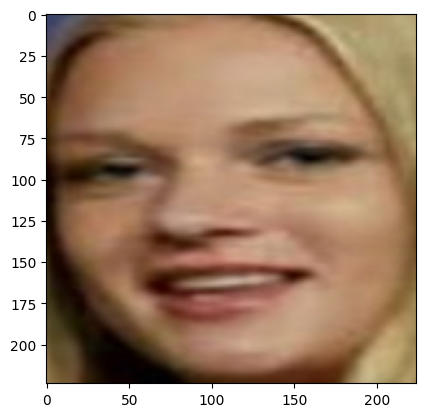

In [4]:
# Cell 4: Preprocess Images
import cv2
import numpy as np

def preprocess_image(image_path):
    img = cv2.imread(image_path)  # Ensure image is read in RGB format, numpy array
    if img is None:
        raise ValueError(f"Image at {image_path} could not be loaded.")

    cropped_image = yolo_preprocessor.process_image(img)
    img_resized = cv2.resize(cropped_image, (224, 224))  # Resize image to 224x224
    return img_resized

# Preprocess a sample image and display it
model_path = 'paste file location of best_3.pt here'
yolo_preprocessor = YoloPreprocessor(model_path)
sample_image_path = dataset.first().filepath
processed_image = preprocess_image(sample_image_path)

import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
plt.show()


In [4]:
# Cell 4: Feature Extraction
def extract_features(image):
    return image.flatten()

features = extract_features(processed_image)# Cell 4: Feature Extraction using ResNet
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array_expanded_dims)
    features = model.predict(img_preprocessed)
    return features.flatten()

# Extract features from a sample image
features = extract_features(sample_image_path)
print("Features shape:", features.shape)

features_np = np.array(features)
print("Features shape:", features_np.shape)

Features shape: (10000,)


In [5]:
# Cell 5: Process and Store Features from Dataset
all_features = []
sample_ids = []

for sample in dataset:
    processed_image = preprocess_image(sample.filepath)
    features = extract_features(processed_image)
    all_features.append(features)
    sample_ids.append(sample.id)

all_features_np = np.array(all_features)
print("All features shape:", all_features_np.shape)

All features shape: (13233, 10000)


In [6]:
# Cell 6: Validations
if len(dataset) == 0:
    print("The dataset is empty. Please check the dataset loading process.")
else:
    print("Dataset loaded successfully with", len(dataset), "samples.")

if len(all_features) == 0:
    print("Feature vectors are not loaded or empty.")
else:
    print("Features loaded successfully with", len(all_features), "feature vectors.")

if len(sample_ids) == 0:
    print("Sample IDs list is not initialized or empty.")
else:
    print("Sample IDs are available with", len(sample_ids), "entries.")


Dataset loaded successfully with 13233 samples.
Features loaded successfully with 13233 feature vectors.
Sample IDs are available with 13233 entries.


In [7]:
# Cell 7: Check Sample IDs
print("Sample IDs (first 5):", sample_ids[:5])

Sample IDs (first 5): ['66185c33d771016b2875a2b9', '66185c33d771016b2875a2be', '66185c33d771016b2875a2bf', '66185c33d771016b2875a2c0', '66185c33d771016b2875a2c1']


In [8]:
# Cell 8: Import Libraries for ResNet
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import numpy as np

# Load ResNet50 model pre-trained on ImageNet data
base_model = ResNet50(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

def extract_features_resnet(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return model.predict(preprocess_input(img_array_expanded_dims)).flatten()


In [9]:
# Cell 9: Extract Features with ResNet
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import numpy as np

base_model = ResNet50(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

def extract_features_resnet(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return model.predict(preprocess_input(img_array_expanded_dims)).flatten()

resnet_features = []
for sample in dataset:
    features = extract_features_resnet(sample.filepath)
    resnet_features.append(features)

resnet_features_np = np.array(resnet_features).astype('float32')  # Ensure the data type is float32 for Faiss
print("ResNet Features shape:", resnet_features_np.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━

In [10]:
# Cell 10: Initialize Faiss Index for Storing Features
import faiss

dimension = 2048  # Dimension of the feature vectors from ResNet
index = faiss.IndexFlatL2(dimension)  # Using L2 distance for similarity
print("Faiss index created.")


Faiss index created.


In [11]:
# Cell 12: Insert Features into Faiss Index
index.add(resnet_features_np)  # Adding features to the index
print("Features added to Faiss index:", index.ntotal)


Features added to Faiss index: 13233


In [12]:
# Cell 13: Search for Similar Faces Using Faiss
def search_similar_faces(query_feature, top_k=5):
    query_feature = np.array([query_feature]).astype('float32')
    distances, indices = index.search(query_feature, top_k)  # Perform the search
    return indices[0], distances[0]

# Example: Search for the first image features
query_feature = resnet_features_np[0]
indices, distances = search_similar_faces(query_feature)
print("Search Results Indices:", indices)
print("Search Results Distances:", distances)


Search Results Indices: [    0 12809  8342  9148  4571]
Search Results Distances: [  0.      317.53076 332.33765 361.11505 373.19214]


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Closest match index: 1283
Distance of closest match: 581.29407


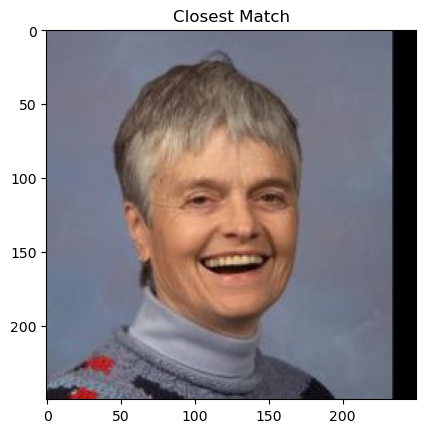

In [16]:
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import fiftyone as fo

# Load the dataset and prepare a mapping from index to filepath
dataset = fo.load_dataset("lfw")
id_to_filepath = {i: sample.filepath for i, sample in enumerate(dataset)}

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

# Function to preprocess and extract features
def preprocess_and_extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array_expanded_dims)
    features = model.predict(img_preprocessed)
    return features.flatten()

# Function to find the closest match
def find_closest_match(query_img_path, index):
    query_features = preprocess_and_extract_features(query_img_path)
    query_features = np.array([query_features]).astype('float32')
    distances, indices = index.search(query_features, 1)  # '1' for the closest match
    return indices[0][0], distances[0][0]

# Assuming you have an image path
query_img_path = "alan.jpg"
closest_index, closest_distance = find_closest_match(query_img_path, index)

print("Closest match index:", closest_index)
print("Distance of closest match:", closest_distance)

# Use the index to ID mapping to retrieve the file path
closest_image_path = id_to_filepath[closest_index]
closest_img = image.load_img(closest_image_path)
plt.imshow(closest_img)
plt.title("Closest Match")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Closest match index: 9280
Distance of closest match: 717.33215


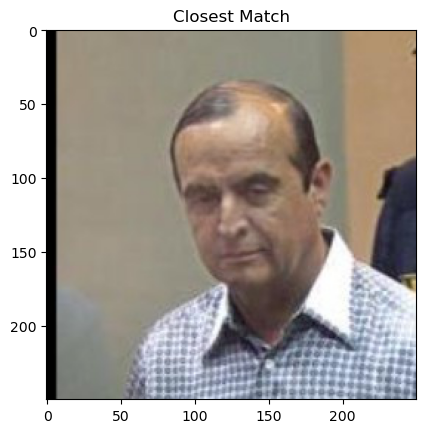

In [18]:
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import fiftyone as fo

# Load the dataset and prepare a mapping from index to filepath
dataset = fo.load_dataset("lfw")
id_to_filepath = {i: sample.filepath for i, sample in enumerate(dataset)}

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

# Function to preprocess and extract features
def preprocess_and_extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array_expanded_dims)
    features = model.predict(img_preprocessed)
    return features.flatten()

# Function to find the closest match
def find_closest_match(query_img_path, index):
    query_features = preprocess_and_extract_features(query_img_path)
    query_features = np.array([query_features]).astype('float32')
    distances, indices = index.search(query_features, 1)  # '1' for the closest match
    return indices[0][0], distances[0][0]

# Assuming you have an image path
query_img_path = "Ryan.jpg"
closest_index, closest_distance = find_closest_match(query_img_path, index)

print("Closest match index:", closest_index)
print("Distance of closest match:", closest_distance)

# Use the index to ID mapping to retrieve the file path
closest_image_path = id_to_filepath[closest_index]
closest_img = image.load_img(closest_image_path)
plt.imshow(closest_img)
plt.title("Closest Match")
plt.show()
